##  Reconstruction Of Images Using RBM on MNIST dataset

* Import the modules

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

* Declare the class RBM. The __init__ function will build the complete graph, forward and backward pass, and the objective function. 
* We use the TensorFlow built-in optimizer to update the weights and biases

In [2]:
class RBM(object):
    def __init__(self, visible, hidden):
        """
        visible: Number of neurons in visible layer
        hidden: number of neurons in hidden layer
        """
        self._visible = visible
        self._hidden = hidden

        # Create the Computational graph
        # Weights and biases
        self._W = tf.Variable(tf.random_normal(shape=(self._visible,self._hidden)))
        self._visible_bias = tf.Variable(np.zeros(self._visible).astype(np.float32)) #bias for Visible layer
        self._hidden_bias = tf.Variable(np.zeros(self._hidden).astype(np.float32)) #bias for Hidden layer

        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._visible])

        # Forward Pass
        _h = tf.nn.sigmoid(tf.matmul(self._X, self._W) + self._hidden_bias)
        self.h = tf.nn.relu(tf.sign(_h -         tf.random_uniform(tf.shape(_h))))

        #Backward pass
        _v = tf.nn.sigmoid(tf.matmul(self.h, tf.transpose(self._W)) + self._visible_bias)
        self.V = tf.nn.relu(tf.sign(_v - tf.random_uniform(tf.shape(_v))))

        # Objective Function
        objective = tf.reduce_mean(self.free_energy(self._X)) - tf.reduce_mean(self.free_energy(self.V))
        self._train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(objective)

        # Cross entropy cost
        reconstructed_input = self.one_pass(self._X)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self._X, logits=reconstructed_input))
    """We define the fit() method in the RBM class. After declaring all the ops in
       __init__, training is simply calling the train_op within the session. 
       We use batch training"""
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size

        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._train_op,self.cost ], feed_dict={self._X: batch})
                if j % 10 == 0:
                    print('training epoch {0} cost {1}'.format(j,ob)) 
                obj.append(ob)
        return obj
    """There are other helper functions to calculate the logit error and return
      reconstructed images from the network"""
    def set_session(self, session):
        self.session = session

    def free_energy(self, V):
        b = tf.reshape(self._visible_bias, (self._visible, 1))
        term_1 = -tf.matmul(V,b)
        term_1 = tf.reshape(term_1, (-1,))
        term_2 = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V,self._W) +
            self._hidden_bias))
        return term_1 + term_2

    def one_pass(self, X):
        h = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return tf.matmul(h, tf.transpose(self._W)) + self._visible_bias

    def reconstruct(self,X):
        x = tf.nn.sigmoid(self.one_pass(X))
        return self.session.run(x, feed_dict={self._X: X})


* Load the MNIST dataset

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_X, train_Y, test_X, test_Y = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


* We train our RBM on the MNIST dataset

In [4]:
X_train = train_X.astype(np.float32)
X_test = test_X.astype(np.float32)
_, m = X_train.shape
rbm = RBM(m, 100)
#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    rbm.set_session(sess)
    err = rbm.fit(X_train)
    out = rbm.reconstruct(X_test[0:100])  # Let us reconstruct Test Data

training epoch 0 cost 2.8835232257843018
training epoch 10 cost 0.554356038570404
training epoch 20 cost 0.4265272319316864
training epoch 30 cost 0.41361626982688904
training epoch 40 cost 0.3575364351272583
training epoch 50 cost 0.350503146648407
training epoch 60 cost 0.3301950991153717
training epoch 70 cost 0.30484238266944885
training epoch 80 cost 0.3391551673412323
training epoch 90 cost 0.34217962622642517
training epoch 100 cost 0.2918216288089752
training epoch 110 cost 0.281596839427948
training epoch 120 cost 0.29105138778686523
training epoch 130 cost 0.279015451669693
training epoch 140 cost 0.28529393672943115
training epoch 150 cost 0.341569185256958
training epoch 160 cost 0.2740691900253296
training epoch 170 cost 0.3370254337787628
training epoch 180 cost 0.2887929379940033
training epoch 190 cost 0.2483990341424942
training epoch 200 cost 0.26531293988227844
training epoch 210 cost 0.26596301794052124
training epoch 220 cost 0.27037668228149414
training epoch 230 

* We can see the original and reconstructed MNIST images by using a small helper plotting code

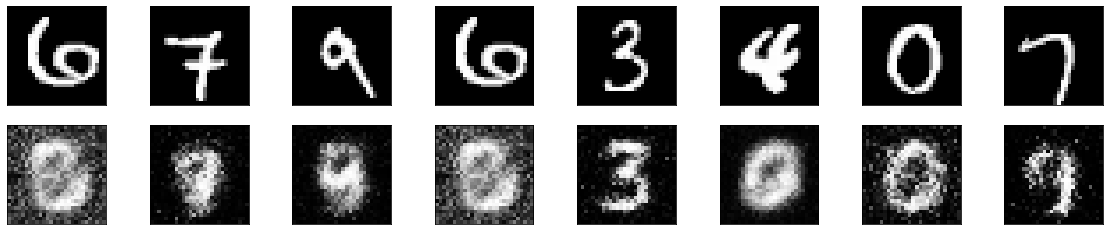

In [5]:
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([X_test,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)